# VIT training from scartch


**installing missing libaraies**

In [ ]:
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

**Importing libaries**

In [ ]:
# Importing and setups
!pip install ptflops
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, roc_curve, auc
import csv
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from ptflops import get_model_complexity_info

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # also need to set cuda seed
np.random.seed(seed)
torch.backends.cudnn.deterministic = True  # reproducible

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cpu':
    print("WARNING: Training will be very slow without GPU!")

Using device: cuda


**Preparing data**

In [ ]:
# Data Preparation with Augmentation
class CIFAR10DataModule:
    def __init__(self, batch_size=128, num_workers=4):
        self.batch_size = batch_size
        self.num_workers = num_workers

        # CIFAR10 normalization values - DON'T CHANGE
        self.mean = (0.4914, 0.4822, 0.4465)
        self.std = (0.2470, 0.2435, 0.2616)

        # Define transformations
        self.train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),  # standard augmentation
            transforms.RandAugment(num_ops=2, magnitude=9),  # tried 3 ops but too aggressive
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

        # No augmentation for test set
        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

    def setup(self):
        # Download datasets
        print("Setting up datasets...")
        self.train_dataset = datasets.CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=self.train_transform
        )

        self.val_dataset = datasets.CIFAR10(
            root='./data',
            train=False,
            download=True,
            transform=self.test_transform
        )
        print(f"Loaded {len(self.train_dataset)} training and {len(self.val_dataset)} validation samples")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,  # important for training!
            num_workers=self.num_workers,
            pin_memory=True  # helps if using GPU
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,  # no need to shuffle for validation
            num_workers=self.num_workers,
            pin_memory=True
        )

**Patch embedding (breaking images into patches and assigning postion)**

In [ ]:
# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Originally used a linear layer here, but conv is more efficient and does the same thing
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # x shape: [B, C, H, W]
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}*{W}) doesn't match expected size ({self.img_size}*{self.img_size})"

        # [B, C, H, W] -> [B, E, H/P, W/P] -> [B, E, (H/P)*(W/P)] -> [B, (H/P)*(W/P), E]
        x = self.proj(x)  # [B, E, H/P, W/P]
        x = x.flatten(2)  # [B, E, (H/P)*(W/P)]
        x = x.transpose(1, 2)  # [B, (H/P)*(W/P), E]

        return x

*Multi Head Attention*



In [ ]:
# Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=192, num_heads=8, dropout=0.1): # 192/8 = 24 per head
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Double-check dimensions
        assert self.head_dim * num_heads == embed_dim, \
            f"embed_dim {embed_dim} must be divisible by num_heads {num_heads}"

        # Combined QKV projections
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)



    def forward(self, x):
        # x shape: [B, N, E] - B=batch, N=sequence_length, E=embedding_dim
        B, N, E = x.shape

        # Project to Q, K, V and reshape for multi-head attention
        # This is that fancy reshape for multi-head attention
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B, H, N, D] - H=heads, D=head_dim

        # Scaled dot-product attention
        # The scaling is super important - training dies without it
        attn = (q @ k.transpose(-2, -1)) * (1.0 / np.sqrt(self.head_dim))  # [B, H, N, N]
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)  # helps generalization

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, E)  # [B, N, E]
        x = self.proj(x)  # final projection
        x = self.proj_dropout(x)

        return x

**Multi Layer Preceptron**

In [ ]:
# MLP Block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        # GELU Better than ReLU for transformers
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)  # second dropout seems to help
        return x

**Encoder only tranformer**

In [ ]:
# Transformer Encoder Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=192, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            in_features=embed_dim,
            hidden_features=int(embed_dim * mlp_ratio),  # the ratio matters!
            out_features=embed_dim,
            dropout=dropout
        )
        # NOTE: we're using pre-norm formulation

    def forward(self, x):
        # Pre-norm formulation - more stable, can train deeper networks
        # x + sublayer(norm(x)) instead of norm(x + sublayer(x))
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

**Complete model putting everything together**


In [ ]:
# Complete Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=32,
        patch_size=4,  # 4x4 patches for CIFAR ie(32^2//4^2 == 64 tokens)
        in_channels=3, # RGB channel
        num_classes=10,# number of expected outputs
        embed_dim=192,  # tried 384 but too many params for CIFAR tend to overfit
        depth=9,  # paper uses 12, but 9 is enough for CIFAR and 12 tend to overfit
        num_heads=8,  # must divide embed_dim evenly 192/8 = 24
        mlp_ratio=4.0,
        dropout=0.1, # probablity of skiping connection ie 10 percent
        embed_dropout=0.1  # separate dropout rate for embeddings
    ):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_tokens = (img_size // patch_size) ** 2

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )

        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Position embeddings - could use sinusoidal but learned works fine
        # postional embeddings are used because we have 8 multi head attention we need assign position for each vector
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens + 1, embed_dim))

        # Initialize weights for faster convergence
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        self.dropout = nn.Dropout(embed_dropout)

        # Transformer blocks - this is the main part of the model
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout
            )
            for _ in range(depth) # we just use for loop instead rewriting tranformer 8 times
        ])

        # Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)

        # Classification head - just a linear layer
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        self.apply(self._init_weights)

        # How many params?
        #print(f"ViT params: {sum(p.numel() for p in self.parameters())}")

    def _init_weights(self, m):
        # Weight initialization matters for transformers!
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # x shape: [B, C, H, W]
        B = x.shape[0]

        # Create patch embeddings
        x = self.patch_embed(x)  # [B, N, E]

        # Add class token - used for final classification
        cls_token = self.cls_token.expand(B, -1, -1)  # [B, 1, E]
        x = torch.cat((cls_token, x), dim=1)  # [B, N+1, E]

        # Add position embeddings and apply dropout
        x = x + self.pos_embed  # broadcasting takes care of batch dim
        x = self.dropout(x)

        # Pass through transformer blocks
        for i, block in enumerate(self.blocks):
            # Could add intermediate supervision here?
            # Tried it, didn't help much, so removed it
            x = block(x)

        # Apply final normalization
        x = self.norm(x)

        # Take class token for classification
        # Could use pooling over all tokens but this works better
        x = x[:, 0]  # just get CLS token

        # Classification head
        x = self.head(x)
        # Could add an extra non-linearity here but linear seems fine

        return x

**Training and eval**

In [ ]:
# Training and Evaluation Utilities
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()  # set model to training mode
    total_loss = 0.0
    correct = 0
    total = 0
    batch_time = 0.0

    # Progress bar
    pbar = tqdm(train_loader, desc="Training")
    start_time = time.time()

    for batch_idx, (data, target) in enumerate(pbar):
        batch_start = time.time()
        data, target = data.to(device), target.to(device)

        # Forward pass
        optimizer.zero_grad()  # clear gradients first
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()

        # Could add gradient clipping here
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # But Adam seems to work fine without it

        optimizer.step()

        # Update learning rate - using per-step scheduler
        if scheduler is not None:
            scheduler.step()

        # Track metrics
        total_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)  # get predicted class
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        # Track batch time
        batch_end = time.time()
        batch_time += (batch_end - batch_start)

        # Update progress bar - helps to see how training is going
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{100. * correct / total:.1f}%",
            #"lr": f"{optimizer.param_groups[0]['lr']:.6f}"  # uncomment for debugging
        })


    epoch_time = time.time() - start_time

    return total_loss / len(train_loader.dataset), 100. * correct / total, epoch_time, batch_time / len(train_loader)


def evaluate(model, val_loader, criterion, device, classes=None, full_metrics=False):
    model.eval()  # set model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    inference_times = []

    # For confusion matrix and per-class metrics
    all_targets = []
    all_predictions = []

    with torch.no_grad():  # no need to track gradients during evaluation
        for data, target in tqdm(val_loader, desc="Evaluation"):
            data, target = data.to(device), target.to(device)

            # Measure inference time
            start_time = time.time()
            output = model(data)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            loss = criterion(output, target)

            # Track metrics
            total_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            # Store targets and predictions for additional metrics
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute aggregate metrics
    avg_loss = total_loss / len(val_loader.dataset)
    accuracy = 100. * correct / total
    avg_inference_time = sum(inference_times) / len(inference_times)

    results = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'inference_time_ms': avg_inference_time * 1000  # Convert to ms
    }

    # Add detailed metrics if requested
    if full_metrics and classes:
        # Calculate per-class precision, recall, f1-score
        # Can't skip this computation - might seem slow but it's useful info
        precision, recall, f1, support = precision_recall_fscore_support(
            all_targets, all_predictions, labels=range(len(classes)), average=None
        )

        # Create confusion matrix
        cm = confusion_matrix(all_targets, all_predictions, labels=range(len(classes)))

        # Add to results
        results['confusion_matrix'] = cm
        results['per_class'] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support
        }
        results['classes'] = classes
        results['targets'] = all_targets
        results['predictions'] = all_predictions

    return results

**Metrics and Visualization**

In [ ]:
# Metrics and Visualization Functions
def calculate_and_plot_metrics(model, val_loader, criterion, device, classes):
    print("Calculating detailed metrics...")
    results = evaluate(model, val_loader, criterion, device, classes, full_metrics=True)

    # results
    cm = results['confusion_matrix']
    per_class = results['per_class']
    targets = results['targets']
    predictions = results['predictions']

    # 1. Plot confusion matrix
    plt.figure(figsize=(10, 8))
    # Tried various colormaps - Blues is most readable
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('vit_confusion_matrix.png', dpi=200)  # higher DPI for paper-quality

    # 2. Plot per-class metrics
    plt.figure(figsize=(12, 6))
    x = np.arange(len(classes))
    width = 0.2  # width of bars

    # Plot bar chart with precision, recall, F1
    plt.bar(x - width, per_class['precision'], width, label='Precision')
    plt.bar(x, per_class['recall'], width, label='Recall')
    plt.bar(x + width, per_class['f1'], width, label='F1-Score')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Per-Class Performance Metrics')
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('vit_per_class_metrics.png')

    # 3. Compute and plot ROC curves (one-vs-rest)
    plt.figure(figsize=(12, 10))

    # Prepare one-hot encoded targets for ROC
    target_one_hot = np.zeros((len(targets), len(classes)))
    for i, t in enumerate(targets):
        target_one_hot[i, t] = 1

    # Get probability outputs for all samples
    # Need to rerun the model to get probabilities
    all_probs = []
    model.eval()
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            outputs = model(data)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)

    all_probs = np.vstack(all_probs)

    # Plot ROC curve for each class
    mean_auc = 0
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(target_one_hot[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        mean_auc += roc_auc
        plt.plot(fpr, tpr, lw=2, label=f'{cls} (AUC = {roc_auc:.2f})')

    mean_auc /= len(classes)

    # Add diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (Mean AUC = {mean_auc:.2f})')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('vit_roc_curves.png')

    # Return metrics for CSV export
    return {
        'accuracy': results['accuracy'],
        'loss': results['loss'],
        'inference_time_ms': results['inference_time_ms'],
        'per_class_precision': per_class['precision'],
        'per_class_recall': per_class['recall'],
        'per_class_f1': per_class['f1'],
        'mean_auc': mean_auc
    }


# Calculate model complexity
def calculate_model_complexity(model, input_size=(3, 32, 32)):
    print("Calculating model complexity...")
    macs, params = get_model_complexity_info(
        model, input_size, as_strings=False, print_per_layer_stat=False
    )

    # Did you know? FLOPs ≈ 2 * MACs
    # ptflops returns MACs, but papers usually report FLOPs
    return {
        'params': params,
        'flops': macs * 2,  # Convert MACs to FLOPs
        'params_millions': params / 1e6,
        'flops_billions': macs * 2 / 1e9
    }


# Export metrics to CSV
def export_metrics_to_csv(metrics, model_name='ViT', filename='model_metrics.csv'):
    # Create directory if it doesn't exist
    os.makedirs('metrics', exist_ok=True)

    # Prepare CSV file path with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filepath = f'metrics/{model_name}_{timestamp}.csv'

    # Flatten nested dictionaries
    flat_metrics = {}
    for key, value in metrics.items():
        if isinstance(value, dict):
            for subkey, subvalue in value.items():
                flat_metrics[f'{key}_{subkey}'] = subvalue
        elif isinstance(value, np.ndarray):
            for i, val in enumerate(value):
                flat_metrics[f'{key}_{i}'] = val
        else:
            flat_metrics[key] = value

    # Write to CSV
    with open(filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write header
        writer.writerow(['Metric', 'Value'])

        # Write metrics
        for key, value in flat_metrics.items():
            writer.writerow([key, value])

    print(f"Metrics exported to {filepath}")

    # Also create a summary CSV for model comparison
    # This is super handy when doing hyperparameter sweeps!
    summary_path = 'metrics/model_comparison.csv'

    # Check if summary file exists, create with header if not
    file_exists = os.path.isfile(summary_path)
    with open(summary_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        if not file_exists:
            writer.writerow([
                'Model', 'Accuracy', 'Loss', 'Params (M)', 'FLOPs (G)',
                'Inference Time (ms)', 'Mean AUC', 'Training Time (s)'
            ])


        writer.writerow([
            model_name,
            metrics['accuracy'],
            metrics['loss'],
            metrics['complexity']['params_millions'],
            metrics['complexity']['flops_billions'],
            metrics['inference_time_ms'],
            metrics['mean_auc'],
            metrics['training_time']
        ])

    print(f"Summary metrics added to {summary_path}")

**Training function**

In [ ]:
# Main Training Function
def train_vit_cifar10(epochs=100, batch_size=128, lr=1e-3, warmup_epochs=5, model_name='ViT'):
    # Setup data
    print(f"\n=== Setting up {model_name} training ===")
    print(f"Epochs: {epochs}, Batch size: {batch_size}, LR: {lr}")

    data_module = CIFAR10DataModule(batch_size=batch_size)
    data_module.setup()
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    # CIFAR-10 classes
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    # Create model - this is the standard ViT config for CIFAR
    model = VisionTransformer(
        img_size=32,
        patch_size=4,  # 4x4 patches, so 8x8=64 patches total
        in_channels=3,
        num_classes=10,
        embed_dim=192,  # tried 384 but it was overkill
        depth=9,
        num_heads=8,  # 192 / 8 = 24 dim per head
        mlp_ratio=4.0,
        dropout=0.1,  # dropout helps a lot on CIFAR
        embed_dropout=0.1
    ).to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Calculate model complexity
    complexity = calculate_model_complexity(model)
    print(f"FLOPs: {complexity['flops_billions']:.2f} G")
    print(f"Parameters: {complexity['params_millions']:.2f} M")

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    #  AdamW works better for transformers
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)

    # Learning rate scheduler - cosine decay with warmup
    # Warmup is crucial for transformer training stability
    total_steps = len(train_loader) * epochs
    warmup_steps = len(train_loader) * warmup_epochs

    # Learning rate schedule
    def lr_lambda(step):
        # Linear warmup + cosine decay
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        # Cosine annealing
        return 0.5 * (1.0 + np.cos(np.pi * float(step - warmup_steps) / float(total_steps - warmup_steps)))

    # Create scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Training loop
    print("\n=== Starting training ===")
    best_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    epoch_times, batch_times = [], []
    total_training_time = 0
    lr_history = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        # Train
        train_loss, train_acc, epoch_time, avg_batch_time = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, device
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        epoch_times.append(epoch_time)
        batch_times.append(avg_batch_time)
        total_training_time += epoch_time

        # Evaluate
        val_results = evaluate(model, val_loader, criterion, device)
        val_loss = val_results['loss']
        val_acc = val_results['accuracy']
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print metrics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Epoch Time: {epoch_time:.2f}s, Avg Batch Time: {avg_batch_time*1000:.2f}ms")
        print(f"Current LR: {current_lr:.6f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "vit_cifar10_best.pth")
            print(f"New best validation accuracy: {best_acc:.2f}%!")
            # Also save at specific checkpoints (optional)
            #if val_acc > 90:
            #    torch.save(model.state_dict(), f"vit_cifar10_{val_acc:.1f}.pth")

        # Early stopping check after a reasonable number of epochs
        # No need to train forever if we're already good
        if epoch >= 50 and best_acc >= 90.0:
            print(f"Reached target accuracy of 90%. Stopping early!")
            break

    print(f"\n=== Training complete ===")
    print(f"Total training time: {total_training_time:.2f}s")
    print(f"Best validation accuracy: {best_acc:.2f}%")

    # Plot final expanded training metrics
    print("\nGenerating final training plots...")
    plt.figure(figsize=(18, 12))

    # 1. Loss curves
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # 2. Accuracy curves
    plt.subplot(2, 3, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curves')
    plt.legend()

    # 3. Epoch times
    plt.subplot(2, 3, 3)
    plt.plot(epoch_times)
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.title('Epoch Training Time')

    # 4. Batch times
    plt.subplot(2, 3, 4)
    plt.plot(batch_times)
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.title('Average Batch Processing Time')

    # 5. Learning rate
    plt.subplot(2, 3, 5)
    plt.plot(lr_history)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    # Add grid for readability
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('vit_training_metrics.png')
    plt.close()  # close to avoid display issues with multiple plots

    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    model.load_state_dict(torch.load("vit_cifar10_best.pth"))

    # Calculate detailed metrics
    detailed_metrics = calculate_and_plot_metrics(model, val_loader, criterion, device, classes)

    # Prepare metrics for export
    final_metrics = {
        'accuracy': best_acc,
        'loss': val_losses[-1],
        'inference_time_ms': detailed_metrics['inference_time_ms'],
        'training_time': total_training_time,
        'epochs': len(train_losses),
        'avg_epoch_time': sum(epoch_times) / len(epoch_times),
        'avg_batch_time': sum(batch_times) / len(batch_times),
        'complexity': complexity,
        'mean_auc': detailed_metrics['mean_auc'],
        'per_class': {
            'precision': detailed_metrics['per_class_precision'],
            'recall': detailed_metrics['per_class_recall'],
            'f1': detailed_metrics['per_class_f1']
        }
    }

    # Export metrics to CSV
    export_metrics_to_csv(final_metrics, model_name)

    print(f"Best validation accuracy: {best_acc:.2f}%")
    return model, best_acc, final_metrics

**Visualize attention**

In [ ]:
# Attention Visualization Function
def visualize_attention(model, dataloader, device, num_images=4):
    # Get some test images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    # Get class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    # Set model to eval mode
    model.eval()


    def get_attention_maps(x):
        B = x.shape[0]
        x = model.patch_embed(x)
        cls_token = model.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + model.pos_embed
        x = model.dropout(x)

        # Pass through transformer blocks except the last one
        for i, block in enumerate(model.blocks[:-1]):
            x = block(x)

        # Get attention from the last block
        # We're interested in how the cls token attends to the patches
        x = model.blocks[-1].norm1(x)  # apply LN first (pre-norm)
        qkv = model.blocks[-1].attn.qkv(x).reshape(B, x.shape[1], 3, model.blocks[-1].attn.num_heads, model.blocks[-1].attn.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (1.0 / np.sqrt(model.blocks[-1].attn.head_dim))
        attn = F.softmax(attn, dim=-1)

        return attn

    with torch.no_grad():
        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Get attention maps
        attentions = get_attention_maps(images)  # shape: [B, H, N, N]

        # Extract attention from the CLS token to all patches
        # Average over all heads for visualization
        cls_attentions = attentions[:, :, 0, 1:].mean(1)  # shape: [B, N-1]

    # Reshape attention maps to match the image patches
    patch_size = 4
    num_patches = 8  # 32 // 4 = 8

    plt.figure(figsize=(16, 4 * num_images))

    for i in range(num_images):
        # Original image - need to denormalize
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)

        # Attention map
        attn_map = cls_attentions[i].reshape(num_patches, num_patches).cpu().numpy()

        # Upsample the attention map to match the image size
        # Simple nearest-neighbor upsampling
        attn_map = np.repeat(np.repeat(attn_map, patch_size, axis=0), patch_size, axis=1)

        # Color indicates attention strength
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(img)
        plt.title(f"Original: {classes[labels[i]]}\nPredicted: {classes[predicted[i]]}")
        plt.axis('off')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(attn_map)
        plt.title("Attention Map")
        plt.axis('off')

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(img)
        plt.imshow(attn_map, alpha=0.5, cmap='jet')  # overlay with some transparency
        plt.title("Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vit_attention_maps.png')
    plt.close()  # close to avoid display issues

**Main Execution**


=== Setting up ViT training ===
Epochs: 100, Batch size: 128, LR: 0.001
Setting up datasets...


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Loaded 50000 training and 10000 validation samples


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Total parameters: 4,028,170
Calculating model complexity...
FLOPs: 0.52 G
Parameters: 4.03 M

=== Starting training ===

Epoch 1/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.24it/s]


Train Loss: 2.0694, Train Acc: 22.25%
Val Loss: 1.8627, Val Acc: 31.10%
Epoch Time: 53.15s, Avg Batch Time: 125.45ms
Current LR: 0.000000
New best validation accuracy: 31.10%!

Epoch 2/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.14it/s]


Train Loss: 1.7875, Train Acc: 33.46%
Val Loss: 1.6427, Val Acc: 41.08%
Epoch Time: 54.27s, Avg Batch Time: 128.50ms
Current LR: 0.000200
New best validation accuracy: 41.08%!

Epoch 3/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.42it/s]


Train Loss: 1.5991, Train Acc: 41.49%
Val Loss: 1.4307, Val Acc: 47.89%
Epoch Time: 54.14s, Avg Batch Time: 129.37ms
Current LR: 0.000400
New best validation accuracy: 47.89%!

Epoch 4/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.44it/s]


Train Loss: 1.5142, Train Acc: 45.13%
Val Loss: 1.2912, Val Acc: 52.89%
Epoch Time: 54.74s, Avg Batch Time: 129.83ms
Current LR: 0.000600
New best validation accuracy: 52.89%!

Epoch 5/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.47it/s]


Train Loss: 1.4667, Train Acc: 46.87%
Val Loss: 1.2890, Val Acc: 52.90%
Epoch Time: 55.06s, Avg Batch Time: 130.17ms
Current LR: 0.000800
New best validation accuracy: 52.90%!

Epoch 6/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.70it/s]


Train Loss: 1.4328, Train Acc: 48.01%
Val Loss: 1.1976, Val Acc: 56.31%
Epoch Time: 55.12s, Avg Batch Time: 130.00ms
Current LR: 0.001000
New best validation accuracy: 56.31%!

Epoch 7/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.51it/s]


Train Loss: 1.3751, Train Acc: 50.52%
Val Loss: 1.1698, Val Acc: 57.02%
Epoch Time: 55.82s, Avg Batch Time: 131.52ms
Current LR: 0.001000
New best validation accuracy: 57.02%!

Epoch 8/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 19.91it/s]


Train Loss: 1.3328, Train Acc: 51.96%
Val Loss: 1.1469, Val Acc: 58.76%
Epoch Time: 54.92s, Avg Batch Time: 129.83ms
Current LR: 0.000999
New best validation accuracy: 58.76%!

Epoch 9/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.13it/s]


Train Loss: 1.2859, Train Acc: 53.61%
Val Loss: 1.1086, Val Acc: 60.08%
Epoch Time: 55.33s, Avg Batch Time: 129.89ms
Current LR: 0.000998
New best validation accuracy: 60.08%!

Epoch 10/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 17.70it/s]


Train Loss: 1.2449, Train Acc: 55.39%
Val Loss: 1.0298, Val Acc: 62.21%
Epoch Time: 55.07s, Avg Batch Time: 129.95ms
Current LR: 0.000996
New best validation accuracy: 62.21%!

Epoch 11/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.62it/s]


Train Loss: 1.2048, Train Acc: 57.03%
Val Loss: 0.9956, Val Acc: 64.12%
Epoch Time: 54.68s, Avg Batch Time: 129.77ms
Current LR: 0.000993
New best validation accuracy: 64.12%!

Epoch 12/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 19.96it/s]


Train Loss: 1.1608, Train Acc: 58.50%
Val Loss: 0.9781, Val Acc: 64.36%
Epoch Time: 54.28s, Avg Batch Time: 128.55ms
Current LR: 0.000990
New best validation accuracy: 64.36%!

Epoch 13/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.53it/s]


Train Loss: 1.1287, Train Acc: 59.95%
Val Loss: 0.9105, Val Acc: 67.30%
Epoch Time: 54.68s, Avg Batch Time: 128.78ms
Current LR: 0.000987
New best validation accuracy: 67.30%!

Epoch 14/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.44it/s]


Train Loss: 1.0951, Train Acc: 61.06%
Val Loss: 0.9410, Val Acc: 66.57%
Epoch Time: 55.05s, Avg Batch Time: 130.12ms
Current LR: 0.000983

Epoch 15/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.36it/s]


Train Loss: 1.0667, Train Acc: 61.92%
Val Loss: 0.8715, Val Acc: 68.42%
Epoch Time: 54.37s, Avg Batch Time: 129.16ms
Current LR: 0.000978
New best validation accuracy: 68.42%!

Epoch 16/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.20it/s]


Train Loss: 1.0368, Train Acc: 63.26%
Val Loss: 0.8368, Val Acc: 70.37%
Epoch Time: 54.13s, Avg Batch Time: 129.00ms
Current LR: 0.000973
New best validation accuracy: 70.37%!

Epoch 17/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 19.97it/s]


Train Loss: 1.0146, Train Acc: 64.22%
Val Loss: 0.8140, Val Acc: 71.06%
Epoch Time: 54.05s, Avg Batch Time: 128.12ms
Current LR: 0.000967
New best validation accuracy: 71.06%!

Epoch 18/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.20it/s]


Train Loss: 0.9888, Train Acc: 65.11%
Val Loss: 0.8293, Val Acc: 70.29%
Epoch Time: 53.96s, Avg Batch Time: 127.60ms
Current LR: 0.000961

Epoch 19/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.87it/s]


Train Loss: 0.9642, Train Acc: 66.15%
Val Loss: 0.7938, Val Acc: 71.47%
Epoch Time: 55.04s, Avg Batch Time: 129.72ms
Current LR: 0.000955
New best validation accuracy: 71.47%!

Epoch 20/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.57it/s]


Train Loss: 0.9475, Train Acc: 66.41%
Val Loss: 0.7539, Val Acc: 73.58%
Epoch Time: 54.76s, Avg Batch Time: 128.90ms
Current LR: 0.000947
New best validation accuracy: 73.58%!

Epoch 21/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.91it/s]


Train Loss: 0.9268, Train Acc: 67.44%
Val Loss: 0.7238, Val Acc: 74.36%
Epoch Time: 54.84s, Avg Batch Time: 129.03ms
Current LR: 0.000940
New best validation accuracy: 74.36%!

Epoch 22/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.26it/s]


Train Loss: 0.9146, Train Acc: 67.72%
Val Loss: 0.7750, Val Acc: 72.45%
Epoch Time: 55.38s, Avg Batch Time: 129.73ms
Current LR: 0.000932

Epoch 23/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.61it/s]


Train Loss: 0.8896, Train Acc: 68.57%
Val Loss: 0.7163, Val Acc: 74.69%
Epoch Time: 54.46s, Avg Batch Time: 129.42ms
Current LR: 0.000923
New best validation accuracy: 74.69%!

Epoch 24/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.60it/s]


Train Loss: 0.8796, Train Acc: 68.86%
Val Loss: 0.6886, Val Acc: 75.79%
Epoch Time: 54.37s, Avg Batch Time: 129.00ms
Current LR: 0.000914
New best validation accuracy: 75.79%!

Epoch 25/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.66it/s]


Train Loss: 0.8608, Train Acc: 69.62%
Val Loss: 0.7286, Val Acc: 74.39%
Epoch Time: 54.51s, Avg Batch Time: 128.79ms
Current LR: 0.000905

Epoch 26/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.54it/s]


Train Loss: 0.8447, Train Acc: 70.22%
Val Loss: 0.6729, Val Acc: 76.16%
Epoch Time: 54.24s, Avg Batch Time: 128.42ms
Current LR: 0.000895
New best validation accuracy: 76.16%!

Epoch 27/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.62it/s]


Train Loss: 0.8294, Train Acc: 70.79%
Val Loss: 0.7406, Val Acc: 73.84%
Epoch Time: 54.49s, Avg Batch Time: 129.46ms
Current LR: 0.000884

Epoch 28/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.81it/s]


Train Loss: 0.8136, Train Acc: 71.43%
Val Loss: 0.6548, Val Acc: 77.00%
Epoch Time: 54.12s, Avg Batch Time: 128.03ms
Current LR: 0.000873
New best validation accuracy: 77.00%!

Epoch 29/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.85it/s]


Train Loss: 0.8063, Train Acc: 71.60%
Val Loss: 0.6824, Val Acc: 76.15%
Epoch Time: 54.06s, Avg Batch Time: 128.86ms
Current LR: 0.000862

Epoch 30/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.76it/s]


Train Loss: 0.7856, Train Acc: 72.52%
Val Loss: 0.6374, Val Acc: 77.83%
Epoch Time: 54.29s, Avg Batch Time: 128.53ms
Current LR: 0.000851
New best validation accuracy: 77.83%!

Epoch 31/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.26it/s]


Train Loss: 0.7794, Train Acc: 72.47%
Val Loss: 0.6545, Val Acc: 77.24%
Epoch Time: 54.44s, Avg Batch Time: 128.68ms
Current LR: 0.000839

Epoch 32/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.28it/s]


Train Loss: 0.7634, Train Acc: 73.04%
Val Loss: 0.6279, Val Acc: 77.79%
Epoch Time: 54.63s, Avg Batch Time: 128.09ms
Current LR: 0.000826

Epoch 33/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.60it/s]


Train Loss: 0.7524, Train Acc: 73.66%
Val Loss: 0.5964, Val Acc: 78.96%
Epoch Time: 54.42s, Avg Batch Time: 128.22ms
Current LR: 0.000814
New best validation accuracy: 78.96%!

Epoch 34/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.74it/s]


Train Loss: 0.7366, Train Acc: 74.04%
Val Loss: 0.5889, Val Acc: 79.14%
Epoch Time: 54.42s, Avg Batch Time: 128.20ms
Current LR: 0.000801
New best validation accuracy: 79.14%!

Epoch 35/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.68it/s]


Train Loss: 0.7314, Train Acc: 74.23%
Val Loss: 0.6302, Val Acc: 77.74%
Epoch Time: 54.71s, Avg Batch Time: 129.02ms
Current LR: 0.000787

Epoch 36/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 19.83it/s]


Train Loss: 0.7215, Train Acc: 74.34%
Val Loss: 0.5819, Val Acc: 79.93%
Epoch Time: 54.17s, Avg Batch Time: 128.82ms
Current LR: 0.000773
New best validation accuracy: 79.93%!

Epoch 37/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.85it/s]


Train Loss: 0.7056, Train Acc: 75.15%
Val Loss: 0.5656, Val Acc: 80.30%
Epoch Time: 54.30s, Avg Batch Time: 128.31ms
Current LR: 0.000759
New best validation accuracy: 80.30%!

Epoch 38/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.66it/s]


Train Loss: 0.6964, Train Acc: 75.26%
Val Loss: 0.5517, Val Acc: 80.76%
Epoch Time: 54.86s, Avg Batch Time: 129.20ms
Current LR: 0.000745
New best validation accuracy: 80.76%!

Epoch 39/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.62it/s]


Train Loss: 0.6909, Train Acc: 75.46%
Val Loss: 0.5619, Val Acc: 80.32%
Epoch Time: 53.95s, Avg Batch Time: 127.73ms
Current LR: 0.000731

Epoch 40/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.68it/s]


Train Loss: 0.6752, Train Acc: 76.26%
Val Loss: 0.5700, Val Acc: 80.01%
Epoch Time: 54.23s, Avg Batch Time: 128.33ms
Current LR: 0.000716

Epoch 41/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.49it/s]


Train Loss: 0.6701, Train Acc: 76.53%
Val Loss: 0.5770, Val Acc: 80.08%
Epoch Time: 53.98s, Avg Batch Time: 128.24ms
Current LR: 0.000701

Epoch 42/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.48it/s]


Train Loss: 0.6601, Train Acc: 76.71%
Val Loss: 0.5382, Val Acc: 81.57%
Epoch Time: 54.43s, Avg Batch Time: 128.76ms
Current LR: 0.000686
New best validation accuracy: 81.57%!

Epoch 43/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.37it/s]


Train Loss: 0.6514, Train Acc: 76.89%
Val Loss: 0.5578, Val Acc: 81.13%
Epoch Time: 55.22s, Avg Batch Time: 129.36ms
Current LR: 0.000670

Epoch 44/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.75it/s]


Train Loss: 0.6403, Train Acc: 77.46%
Val Loss: 0.5435, Val Acc: 81.44%
Epoch Time: 54.28s, Avg Batch Time: 128.14ms
Current LR: 0.000655

Epoch 45/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.76it/s]


Train Loss: 0.6274, Train Acc: 77.77%
Val Loss: 0.5424, Val Acc: 81.59%
Epoch Time: 54.59s, Avg Batch Time: 128.52ms
Current LR: 0.000639
New best validation accuracy: 81.59%!

Epoch 46/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.48it/s]


Train Loss: 0.6223, Train Acc: 78.04%
Val Loss: 0.5999, Val Acc: 79.97%
Epoch Time: 54.83s, Avg Batch Time: 129.48ms
Current LR: 0.000623

Epoch 47/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.87it/s]


Train Loss: 0.6143, Train Acc: 78.29%
Val Loss: 0.5235, Val Acc: 81.80%
Epoch Time: 53.88s, Avg Batch Time: 128.35ms
Current LR: 0.000607
New best validation accuracy: 81.80%!

Epoch 48/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.77it/s]


Train Loss: 0.6060, Train Acc: 78.65%
Val Loss: 0.5336, Val Acc: 81.83%
Epoch Time: 54.87s, Avg Batch Time: 128.54ms
Current LR: 0.000590
New best validation accuracy: 81.83%!

Epoch 49/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.68it/s]


Train Loss: 0.5891, Train Acc: 79.17%
Val Loss: 0.5204, Val Acc: 82.46%
Epoch Time: 54.35s, Avg Batch Time: 128.59ms
Current LR: 0.000574
New best validation accuracy: 82.46%!

Epoch 50/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.59it/s]


Train Loss: 0.5824, Train Acc: 79.44%
Val Loss: 0.5233, Val Acc: 82.10%
Epoch Time: 54.03s, Avg Batch Time: 127.71ms
Current LR: 0.000558

Epoch 51/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.46it/s]


Train Loss: 0.5805, Train Acc: 79.32%
Val Loss: 0.4911, Val Acc: 82.85%
Epoch Time: 54.71s, Avg Batch Time: 129.21ms
Current LR: 0.000541
New best validation accuracy: 82.85%!

Epoch 52/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.29it/s]


Train Loss: 0.5674, Train Acc: 79.84%
Val Loss: 0.4951, Val Acc: 82.91%
Epoch Time: 54.34s, Avg Batch Time: 127.88ms
Current LR: 0.000525
New best validation accuracy: 82.91%!

Epoch 53/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.49it/s]


Train Loss: 0.5591, Train Acc: 80.33%
Val Loss: 0.5098, Val Acc: 82.81%
Epoch Time: 54.28s, Avg Batch Time: 128.40ms
Current LR: 0.000508

Epoch 54/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 19.94it/s]


Train Loss: 0.5475, Train Acc: 80.71%
Val Loss: 0.5015, Val Acc: 83.00%
Epoch Time: 54.53s, Avg Batch Time: 128.66ms
Current LR: 0.000492
New best validation accuracy: 83.00%!

Epoch 55/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.01it/s]


Train Loss: 0.5392, Train Acc: 80.99%
Val Loss: 0.5150, Val Acc: 82.48%
Epoch Time: 54.46s, Avg Batch Time: 127.52ms
Current LR: 0.000475

Epoch 56/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.67it/s]


Train Loss: 0.5372, Train Acc: 80.91%
Val Loss: 0.5119, Val Acc: 82.46%
Epoch Time: 55.04s, Avg Batch Time: 129.11ms
Current LR: 0.000459

Epoch 57/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.47it/s]


Train Loss: 0.5262, Train Acc: 81.21%
Val Loss: 0.4878, Val Acc: 83.32%
Epoch Time: 54.67s, Avg Batch Time: 128.52ms
Current LR: 0.000442
New best validation accuracy: 83.32%!

Epoch 58/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.41it/s]


Train Loss: 0.5189, Train Acc: 81.72%
Val Loss: 0.4739, Val Acc: 83.94%
Epoch Time: 54.47s, Avg Batch Time: 128.79ms
Current LR: 0.000426
New best validation accuracy: 83.94%!

Epoch 59/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.69it/s]


Train Loss: 0.5035, Train Acc: 82.03%
Val Loss: 0.5018, Val Acc: 83.04%
Epoch Time: 55.07s, Avg Batch Time: 128.78ms
Current LR: 0.000410

Epoch 60/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.87it/s]


Train Loss: 0.4988, Train Acc: 82.46%
Val Loss: 0.4782, Val Acc: 83.96%
Epoch Time: 54.69s, Avg Batch Time: 128.51ms
Current LR: 0.000393
New best validation accuracy: 83.96%!

Epoch 61/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.51it/s]


Train Loss: 0.4957, Train Acc: 82.32%
Val Loss: 0.4662, Val Acc: 84.18%
Epoch Time: 54.45s, Avg Batch Time: 128.10ms
Current LR: 0.000377
New best validation accuracy: 84.18%!

Epoch 62/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.66it/s]


Train Loss: 0.4814, Train Acc: 82.92%
Val Loss: 0.4823, Val Acc: 84.10%
Epoch Time: 55.14s, Avg Batch Time: 130.19ms
Current LR: 0.000361

Epoch 63/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.07it/s]


Train Loss: 0.4793, Train Acc: 83.00%
Val Loss: 0.4725, Val Acc: 84.17%
Epoch Time: 54.95s, Avg Batch Time: 129.15ms
Current LR: 0.000345

Epoch 64/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.32it/s]


Train Loss: 0.4672, Train Acc: 83.61%
Val Loss: 0.4729, Val Acc: 84.61%
Epoch Time: 55.03s, Avg Batch Time: 129.44ms
Current LR: 0.000330
New best validation accuracy: 84.61%!

Epoch 65/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.33it/s]


Train Loss: 0.4635, Train Acc: 83.72%
Val Loss: 0.4695, Val Acc: 84.06%
Epoch Time: 55.12s, Avg Batch Time: 129.27ms
Current LR: 0.000314

Epoch 66/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.32it/s]


Train Loss: 0.4629, Train Acc: 83.54%
Val Loss: 0.4630, Val Acc: 84.63%
Epoch Time: 54.65s, Avg Batch Time: 129.58ms
Current LR: 0.000299
New best validation accuracy: 84.63%!

Epoch 67/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.08it/s]


Train Loss: 0.4470, Train Acc: 84.25%
Val Loss: 0.4633, Val Acc: 84.92%
Epoch Time: 55.13s, Avg Batch Time: 129.69ms
Current LR: 0.000284
New best validation accuracy: 84.92%!

Epoch 68/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.64it/s]


Train Loss: 0.4416, Train Acc: 84.39%
Val Loss: 0.4799, Val Acc: 84.60%
Epoch Time: 54.91s, Avg Batch Time: 129.40ms
Current LR: 0.000269

Epoch 69/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.92it/s]


Train Loss: 0.4337, Train Acc: 84.58%
Val Loss: 0.4612, Val Acc: 84.91%
Epoch Time: 54.86s, Avg Batch Time: 128.75ms
Current LR: 0.000255

Epoch 70/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.43it/s]


Train Loss: 0.4237, Train Acc: 84.94%
Val Loss: 0.4723, Val Acc: 84.98%
Epoch Time: 55.07s, Avg Batch Time: 129.11ms
Current LR: 0.000241
New best validation accuracy: 84.98%!

Epoch 71/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.19it/s]


Train Loss: 0.4154, Train Acc: 85.38%
Val Loss: 0.4601, Val Acc: 85.30%
Epoch Time: 55.05s, Avg Batch Time: 128.36ms
Current LR: 0.000227
New best validation accuracy: 85.30%!

Epoch 72/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.35it/s]


Train Loss: 0.4115, Train Acc: 85.48%
Val Loss: 0.4567, Val Acc: 85.47%
Epoch Time: 54.86s, Avg Batch Time: 128.96ms
Current LR: 0.000213
New best validation accuracy: 85.47%!

Epoch 73/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.27it/s]


Train Loss: 0.4015, Train Acc: 85.83%
Val Loss: 0.4512, Val Acc: 85.57%
Epoch Time: 55.20s, Avg Batch Time: 129.24ms
Current LR: 0.000199
New best validation accuracy: 85.57%!

Epoch 74/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.33it/s]


Train Loss: 0.3963, Train Acc: 85.98%
Val Loss: 0.4545, Val Acc: 85.56%
Epoch Time: 54.93s, Avg Batch Time: 129.37ms
Current LR: 0.000186

Epoch 75/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.43it/s]


Train Loss: 0.3883, Train Acc: 86.09%
Val Loss: 0.4538, Val Acc: 85.88%
Epoch Time: 54.66s, Avg Batch Time: 128.49ms
Current LR: 0.000174
New best validation accuracy: 85.88%!

Epoch 76/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.53it/s]


Train Loss: 0.3866, Train Acc: 86.35%
Val Loss: 0.4623, Val Acc: 85.23%
Epoch Time: 55.36s, Avg Batch Time: 129.99ms
Current LR: 0.000161

Epoch 77/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.87it/s]


Train Loss: 0.3818, Train Acc: 86.44%
Val Loss: 0.4621, Val Acc: 85.28%
Epoch Time: 55.05s, Avg Batch Time: 129.03ms
Current LR: 0.000149

Epoch 78/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.63it/s]


Train Loss: 0.3736, Train Acc: 86.78%
Val Loss: 0.4615, Val Acc: 85.52%
Epoch Time: 54.93s, Avg Batch Time: 129.41ms
Current LR: 0.000138

Epoch 79/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.04it/s]


Train Loss: 0.3675, Train Acc: 87.07%
Val Loss: 0.4647, Val Acc: 85.65%
Epoch Time: 55.16s, Avg Batch Time: 129.34ms
Current LR: 0.000127

Epoch 80/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.41it/s]


Train Loss: 0.3639, Train Acc: 87.02%
Val Loss: 0.4585, Val Acc: 85.64%
Epoch Time: 54.79s, Avg Batch Time: 129.18ms
Current LR: 0.000116

Epoch 81/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.49it/s]


Train Loss: 0.3577, Train Acc: 87.31%
Val Loss: 0.4548, Val Acc: 85.95%
Epoch Time: 55.26s, Avg Batch Time: 129.35ms
Current LR: 0.000105
New best validation accuracy: 85.95%!

Epoch 82/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.64it/s]


Train Loss: 0.3546, Train Acc: 87.37%
Val Loss: 0.4457, Val Acc: 86.17%
Epoch Time: 55.24s, Avg Batch Time: 129.57ms
Current LR: 0.000095
New best validation accuracy: 86.17%!

Epoch 83/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.37it/s]


Train Loss: 0.3453, Train Acc: 87.67%
Val Loss: 0.4564, Val Acc: 85.88%
Epoch Time: 54.66s, Avg Batch Time: 128.48ms
Current LR: 0.000086

Epoch 84/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.41it/s]


Train Loss: 0.3440, Train Acc: 87.83%
Val Loss: 0.4526, Val Acc: 85.98%
Epoch Time: 55.19s, Avg Batch Time: 129.67ms
Current LR: 0.000077

Epoch 85/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.47it/s]


Train Loss: 0.3398, Train Acc: 87.99%
Val Loss: 0.4620, Val Acc: 85.86%
Epoch Time: 54.66s, Avg Batch Time: 128.68ms
Current LR: 0.000068

Epoch 86/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.35it/s]


Train Loss: 0.3349, Train Acc: 88.08%
Val Loss: 0.4601, Val Acc: 85.89%
Epoch Time: 54.63s, Avg Batch Time: 128.77ms
Current LR: 0.000060

Epoch 87/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.58it/s]


Train Loss: 0.3320, Train Acc: 88.24%
Val Loss: 0.4536, Val Acc: 86.17%
Epoch Time: 54.87s, Avg Batch Time: 129.33ms
Current LR: 0.000053

Epoch 88/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 19.80it/s]


Train Loss: 0.3308, Train Acc: 88.08%
Val Loss: 0.4445, Val Acc: 86.26%
Epoch Time: 54.64s, Avg Batch Time: 128.46ms
Current LR: 0.000045
New best validation accuracy: 86.26%!

Epoch 89/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.66it/s]


Train Loss: 0.3294, Train Acc: 88.37%
Val Loss: 0.4546, Val Acc: 86.12%
Epoch Time: 54.52s, Avg Batch Time: 128.19ms
Current LR: 0.000039

Epoch 90/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.08it/s]


Train Loss: 0.3244, Train Acc: 88.49%
Val Loss: 0.4511, Val Acc: 86.18%
Epoch Time: 54.85s, Avg Batch Time: 128.88ms
Current LR: 0.000033

Epoch 91/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


Train Loss: 0.3207, Train Acc: 88.74%
Val Loss: 0.4556, Val Acc: 86.28%
Epoch Time: 54.67s, Avg Batch Time: 128.48ms
Current LR: 0.000027
New best validation accuracy: 86.28%!

Epoch 92/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.25it/s]


Train Loss: 0.3198, Train Acc: 88.67%
Val Loss: 0.4532, Val Acc: 86.45%
Epoch Time: 55.17s, Avg Batch Time: 128.56ms
Current LR: 0.000022
New best validation accuracy: 86.45%!

Epoch 93/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 18.57it/s]


Train Loss: 0.3163, Train Acc: 88.66%
Val Loss: 0.4497, Val Acc: 86.30%
Epoch Time: 54.91s, Avg Batch Time: 128.56ms
Current LR: 0.000017

Epoch 94/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.08it/s]


Train Loss: 0.3118, Train Acc: 89.02%
Val Loss: 0.4479, Val Acc: 86.48%
Epoch Time: 54.61s, Avg Batch Time: 128.48ms
Current LR: 0.000013
New best validation accuracy: 86.48%!

Epoch 95/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.74it/s]


Train Loss: 0.3172, Train Acc: 88.74%
Val Loss: 0.4509, Val Acc: 86.40%
Epoch Time: 55.11s, Avg Batch Time: 129.50ms
Current LR: 0.000010

Epoch 96/100


Evaluation: 100%|██████████| 79/79 [00:04<00:00, 19.47it/s]


Train Loss: 0.3151, Train Acc: 88.82%
Val Loss: 0.4517, Val Acc: 86.35%
Epoch Time: 54.51s, Avg Batch Time: 128.81ms
Current LR: 0.000007

Epoch 97/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.58it/s]


Train Loss: 0.3098, Train Acc: 88.94%
Val Loss: 0.4520, Val Acc: 86.42%
Epoch Time: 54.60s, Avg Batch Time: 128.48ms
Current LR: 0.000004

Epoch 98/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 20.20it/s]


Train Loss: 0.3156, Train Acc: 88.84%
Val Loss: 0.4512, Val Acc: 86.40%
Epoch Time: 54.85s, Avg Batch Time: 128.78ms
Current LR: 0.000002

Epoch 99/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.47it/s]


Train Loss: 0.3134, Train Acc: 88.85%
Val Loss: 0.4515, Val Acc: 86.41%
Epoch Time: 54.60s, Avg Batch Time: 128.85ms
Current LR: 0.000001

Epoch 100/100


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.33it/s]


Train Loss: 0.3075, Train Acc: 89.13%
Val Loss: 0.4514, Val Acc: 86.39%
Epoch Time: 55.11s, Avg Batch Time: 129.33ms
Current LR: 0.000000

=== Training complete ===
Total training time: 5468.17s
Best validation accuracy: 86.48%

Generating training plots...

Loading best model for final evaluation...
Calculating detailed metrics...


Evaluation: 100%|██████████| 79/79 [00:03<00:00, 21.73it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Metrics exported to metrics/ViT_20250413_200124.csv
Summary metrics added to metrics/model_comparison.csv
Best validation accuracy: 86.48%
Setting up datasets...
Loaded 50000 training and 10000 validation samples
Visualizing attention maps


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


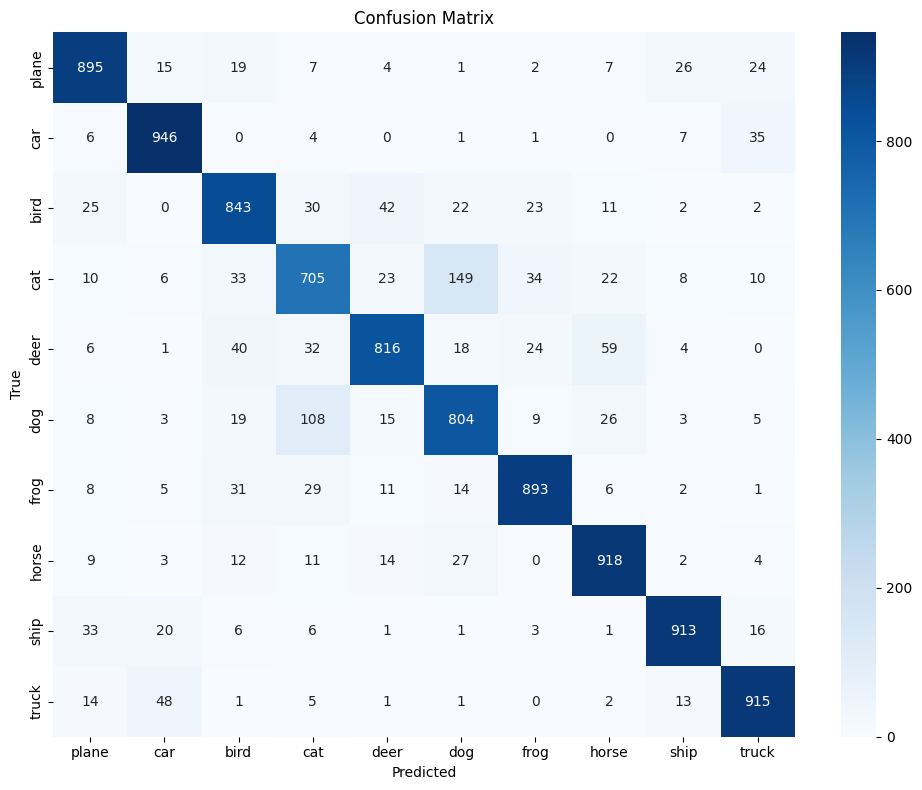

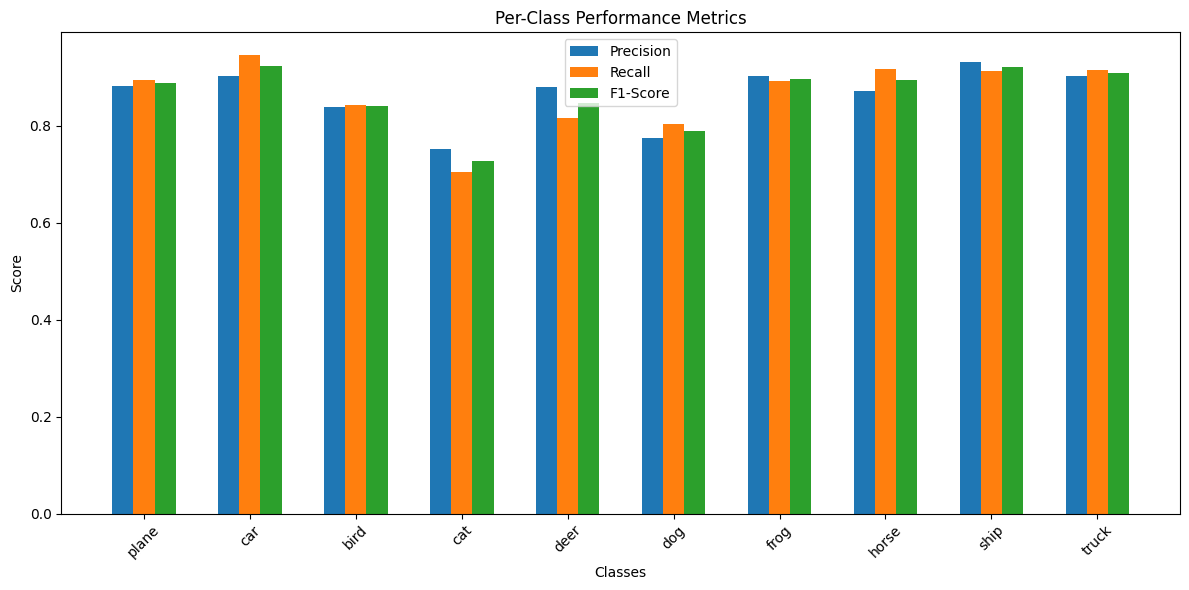

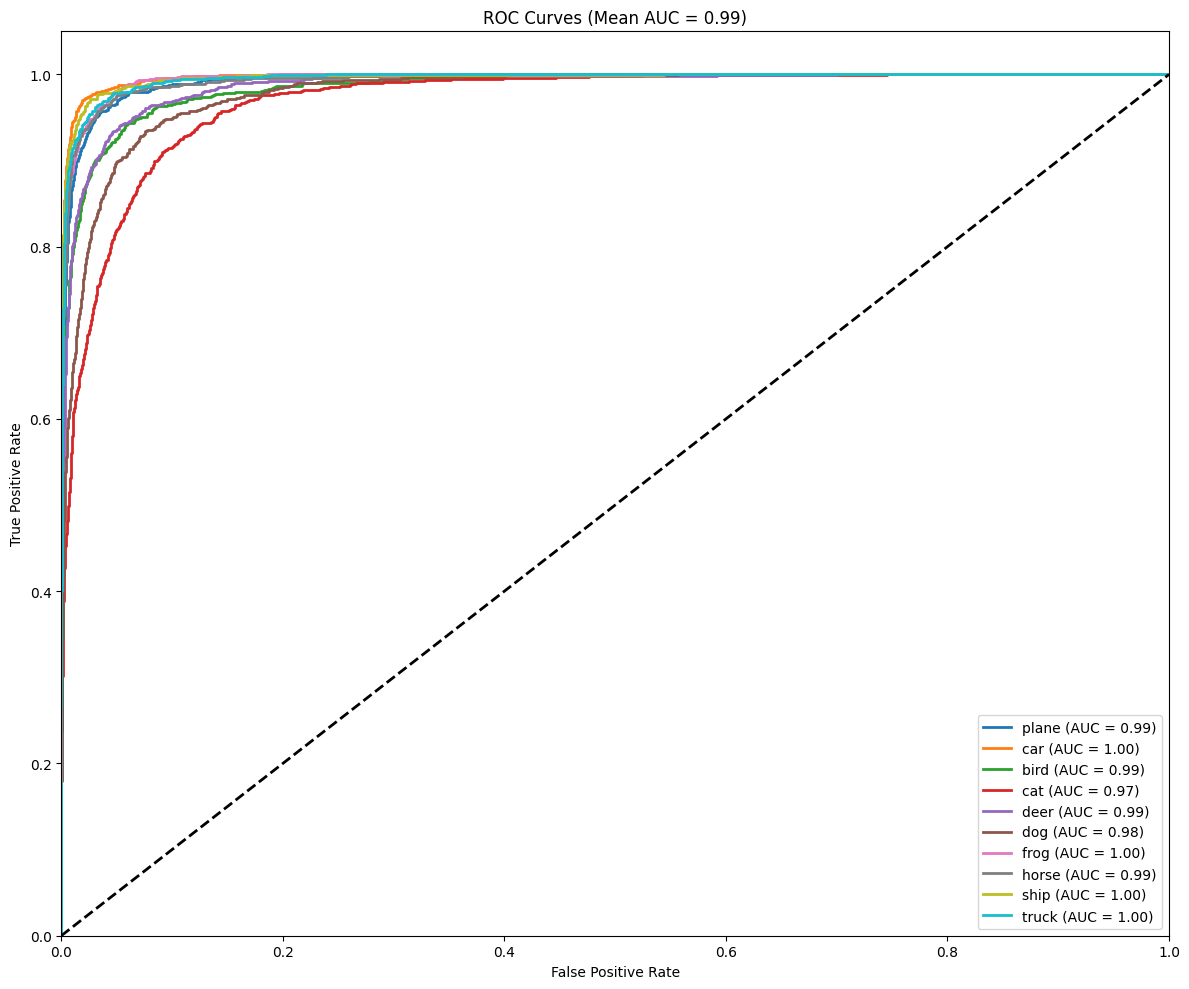

In [ ]:
# Main Execution
if __name__ == "__main__":
    # Create models directory
    os.makedirs('metrics', exist_ok=True)

    # Train the model
    # You can customize these hyperparameters
    model, best_acc, metrics = train_vit_cifar10(
        epochs=100,      # max epochs
        batch_size=128,  # reduce if OOM
        lr=1e-3,         # tried 5e-4 and 3e-3, this works best
        warmup_epochs=5, # helps stabilize training
        model_name='ViT' # for saving metrics
    )

    # Visualize attention if we did well
    data_module = CIFAR10DataModule(batch_size=4)
    data_module.setup()
    val_loader = data_module.val_dataloader()

    print("Visualizing attention maps")
    visualize_attention(model, val_loader, device)

# VIT inference

**Imports and setup**

In [ ]:
!pip install -q matplotlib torchvision  # -q to avoid flooding the output

# Import all the stuff we need
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from google.colab import files
import os
from torchvision import transforms

# Check if we have a GPU ,infernce on gpu is better
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cpu':
    print("Warning: slow without GPU acceleration!")

# CIFAR-10 class names
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.6 MB/s eta 0:00:00
Using device: cpu


**Patch embedding module**

In [ ]:
# Patch Embedding Module
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding - splits the image into patches """
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2  # number of patches

        # This conv does the patch embedding - simpler than manual reshaping
        # Tried using nn.Unfold first but conv is cleaner
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # Make sure image size is right - this saved me once when I fed in 224px images!
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})"

        # (B, C, H, W) -> (B, E, H//P, W//P) -> (B, E, N) -> (B, N, E)
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

**Attention module**

In [ ]:
# Attention Module
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # Scale factor - super important! Training explodes without this
        self.scale = head_dim ** -0.5

        # Combined QKV projection - faster than separate projections
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        # Tried adding a parameter here to control attention strength
        # but it didn't really help
        #self.attn_scale = nn.Parameter(torch.ones(1))

    def forward(self, x):
        B, N, C = x.shape
        # This reshape is tricky but important for multi-head attention
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # separate Q, K, V

        # Compute attention scores - (B, H, N, N)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        #attn = attn * self.attn_scale  # optional extra scaling (commented out)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn  # return attention weights for visualization

**MLP module**

In [ ]:
# MLP Module
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()  # GELU > ReLU for transformers, apparently
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        # Debug flag for printing layer activations
        self.debug = False

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)

        # Optional debugging
        if self.debug and torch.rand(1).item() < 0.01:  # only print occasionally
            print(f"MLP activations: mean={x.mean().item():.3f}, std={x.std().item():.3f}")

        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

**Transformer block**

In [ ]:
# Transformer Block
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias,
                             attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), drop=drop)

        # Could add a stochastic depth (drop path) here for regularization
        # But it's not necessary for inference

    def forward(self, x):
        # Pre-norm architecture - more stable than post-norm
        norm_x = self.norm1(x)
        attn_output, attn_weights = self.attn(norm_x)
        x = x + attn_output  # residual connection
        x = x + self.mlp(self.norm2(x))  # another residual
        return x, attn_weights

**Complete Vision Transformer model**

In [ ]:
# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=192, depth=9,
                 num_heads=8, mlp_ratio=4., qkv_bias=True, drop_rate=0., attn_drop_rate=0.):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.img_size = img_size
        self.patch_size = patch_size


        # Patch embedding
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size,
                                      in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        # Could use fixed sinusoidal embeddings, but learned ones seem better

        self.pos_drop = nn.Dropout(p=drop_rate)

        # Transformer blocks - stack of identical blocks
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                drop=drop_rate, attn_drop=attn_drop_rate)
            for i in range(depth)])

        # Normalization and classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Could use different pooling strategies:
        # 1. CLS token (what we're using)
        # 2. Mean pooling over all tokens
        # 3. Both concatenated
        # But CLS token works best in most cases

    def forward(self, x):
        # Patch embedding [B, N, E]
        x = self.patch_embed(x)
        B = x.shape[0]

        # Append class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add position embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Storage for visualization
        attn_weights = None

        # Apply transformer blocks - save attention from last block
        for i, block in enumerate(self.blocks[:-1]):
            x, _ = block(x)
            # Could save intermediate features here
            # if i == len(self.blocks) // 2:
            #     mid_features = x

        # Last block - save attention weights for visualization
        x, attn_weights = self.blocks[-1](x)

        # Apply final normalization
        x = self.norm(x)

        # Use class token for classification
        x = self.head(x[:, 0])

        return x, attn_weights

    # Unused sinusoidal embedding function - kept for reference
    # def get_sinusoidal_embedding(self):
    #     # Implementation of fixed position embeddings
    #     pass

**Model loading function**

In [ ]:
#  Model Loading Function
def load_model(model_path):
    try:
        print("Loading model state dictionary...")
        # Load state dictionary - added weights_only to avoid optimizers
        state_dict = torch.load(model_path, map_location=device, weights_only=True)

        # Create a new model instance
        vit = VisionTransformer(
            img_size=32,  # CIFAR size
            patch_size=4,  # 4x4 patches → 8x8 = 64 patches total
            in_chans=3,
            num_classes=10,
            embed_dim=192,  # could be 384 for bigger models
            depth=9,      # number of transformer blocks
            num_heads=8,  # attention heads - must divide embed_dim evenly
            mlp_ratio=4.0,  # multiplier for hidden dim in MLP
            qkv_bias=True,  # helps training
            drop_rate=0.0,  # no dropout for inference
            attn_drop_rate=0.0
        ).to(device)

        # Check key names - sometimes need to adapt based on different exports
        # model_keys = set(state_dict.keys())
        # our_keys = set(vit.state_dict().keys())
        # if model_keys != our_keys:
        #     print(f"Warning: Key mismatch. Missing: {our_keys - model_keys}")

        # Load the weights
        vit.load_state_dict(state_dict)
        vit.eval()  # IMPORTANT! Set to evaluation mode
        print("Model loaded successfully!")

        # Could print model summary but torch.summary not in default install
        # from torchsummary import summary
        # summary(vit, (3, 32, 32))

        return vit

    except Exception as e:
        print(f"Error loading model: {e}")
        print("\nIf you're getting key mismatches, here's some debug info:")
        print("For your uploaded model:")
        try:
            state_dict = torch.load(model_path, map_location=device, weights_only=True)
            # Just show a few keys to avoid flooding output
            print(f"Keys in your model: {list(state_dict.keys())[:5]}... (first 5 only)")
        except:
            print("Could not load state dictionary to show keys.")

        print("\nFor the inference model:")
        model = VisionTransformer()
        print(f"Keys expected: {list(model.state_dict().keys())[:5]}... (first 5 only)")


        return None

**Image preprocessing**

In [ ]:
# Image Preprocessing Function
def preprocess_image(image_data):
    # Open image from uploaded bytes
    img = Image.open(io.BytesIO(image_data)).convert('RGB')
    orig_size = img.size
    img_copy = img.copy()  # keep an unmodified copy

    # CIFAR preprocessing - critical to match training!
    # The normalization values are important - don't change
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # ViT needs fixed size
        transforms.ToTensor(),
        # CIFAR-10 mean/std - different from ImageNet values
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    # Convert to tensor and add batch dimension
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Quick check for NaN values
    if torch.isnan(img_tensor).any():
        print("Warning: NaN values in processed image!")

    return img_tensor, img_copy, orig_size

**Image classification**

In [ ]:
# Image Classification Function
def classify_image(model, img_tensor):
    # No gradient tracking needed for inference
    with torch.no_grad():
        # Forward pass through the model
        logits, attn_weights = model(img_tensor)

        # Optional logit range check
        # print(f"Logit range: {logits.min().item():.2f} to {logits.max().item():.2f}")

        # Convert to probabilities with softmax
        probs = F.softmax(logits, dim=1)[0]

        # Get top 3 predictions (could change to top-5 for more classes)
        top3_probs, top3_idx = torch.topk(probs, 3)
        # Convert to percentages
        top3_probs = top3_probs.cpu().numpy() * 100
        top3_classes = [CLASSES[idx] for idx in top3_idx.cpu().numpy()]

    return top3_classes, top3_probs, attn_weights

**Results visualization**

In [ ]:
# Results Visualization Function
def visualize_results(image, top_classes, top_probs):
    plt.figure(figsize=(10, 5))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Prediction: {top_classes[0]}")
    plt.axis('off')

    # Show top 3 predictions
    plt.subplot(1, 2, 2)
    # First prediction in blue, others in gray
    colors = ['#3498db', '#95a5a6', '#95a5a6']  # blue, gray, gray
    bars = plt.barh(top_classes, top_probs, color=colors)
    plt.xlim([0, 100])  # percentages from 0-100
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')

    # Add confidence values as text
    for bar, prob in zip(bars, top_probs):
        plt.text(min(prob + 3, 95), bar.get_y() + bar.get_height()/2, f"{prob:.1f}%",
                 va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

**Attention visualization**

In [ ]:
# Attention Visualization Function
def visualize_attention(model, image, attn_weights, original_size):
    # Get attention from class token to patches
    # Averaging over all attention heads for visualization
    cls_attn = attn_weights[0, :, 0, 1:].mean(0).cpu().numpy()

    # Originally had a for-loop going through each head
    # but the averaged version is cleaner
    # for head in range(attn_weights.shape[1]):
    #     head_attn = attn_weights[0, head, 0, 1:].cpu().numpy()
    #     # ... show each head separately

    # Reshape to match image patches
    patch_size = model.patch_size
    num_patches_per_side = model.img_size // patch_size
    attn_map = cls_attn.reshape(num_patches_per_side, num_patches_per_side)

    # Tried bilinear upsampling but nearest neighbor works fine
    # from skimage.transform import resize
    # attn_map = resize(attn_map, (model.img_size, model.img_size), order=1)

    # Upsample attention map to match image size - simple nearest neighbor
    attn_map = np.repeat(np.repeat(attn_map, patch_size, axis=0), patch_size, axis=1)

    # Display everything
    plt.figure(figsize=(15, 5))

    # Original image (resized to model input size)
    plt.subplot(1, 3, 1)
    plt.imshow(image.resize((32, 32)))
    plt.title("Original Image")
    plt.axis('off')

    # Attention heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(attn_map, cmap='viridis')  # viridis is better than jet
    plt.title("Attention Map")
    plt.axis('off')

    # plt.colorbar(label='Attention')

    # Overlay attention on image
    plt.subplot(1, 3, 3)
    plt.imshow(image.resize((32, 32)))
    plt.imshow(attn_map, alpha=0.5, cmap='jet')  # jet works better for overlay
    plt.title("Attention Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

**Main inference function**

In [ ]:
# Main Inference Function
def run_inference():
    print("=== Vision Transformer Image Classification ===")
    print("Let's classify some images using a ViT model!")

    # Check for existing model or upload new one
    model_path = 'vit_cifar10_best.pth'
    if not os.path.exists(model_path):
        print("\n1. Please upload your trained ViT model file (.pth):")
        print("   (If you don't have one, try the sample model from the repo)")
        uploaded = files.upload()
        if not uploaded:
            print("No model was uploaded. Please run again.")
            return
        model_path = list(uploaded.keys())[0]
        print(f"Using model: {model_path}")

    # Load the model
    model = load_model(model_path)

    if model is None:
        print("\nUnable to load model. If you're seeing key mismatches,")
        print("you might need to adjust the model architecture to match your checkpoint.")
        return

    # Upload image
    print("\n2. Now upload an image to classify:")
    print("   (Try a picture of a car, plane, cat, or anything from CIFAR-10 classes)")
    uploaded = files.upload()

    if not uploaded:
        print("No image was uploaded. Please run again.")
        return

    # Process each uploaded image
    for filename, file_data in uploaded.items():
        print(f"\nProcessing image: {filename}")

        # Preprocess image for the model
        image_tensor, original_image, original_size = preprocess_image(file_data)

        # Run classification
        top_classes, top_probs, attn_weights = classify_image(model, image_tensor)

        # Show results
        print(f"\nResults:")
        print(f"Top Prediction: {top_classes[0]} ({top_probs[0]:.1f}%)")
        print(f"2nd Prediction: {top_classes[1]} ({top_probs[1]:.1f}%)")
        print(f"3rd Prediction: {top_classes[2]} ({top_probs[2]:.1f}%)")

        # Add confidence interpretation
        if top_probs[0] > 90:
            print("Very confident prediction!")
        elif top_probs[0] > 70:
            print("Fairly confident prediction.")
        else:
            print("The model seems unsure - check the attention map for clues.")

        # Show the plots
        visualize_results(original_image, top_classes, top_probs)

        # Visualize attention
        print("\nVisualizing attention map (what the model focuses on):")
        visualize_attention(model, original_image, attn_weights, original_size)

        print("\nThe brightness in the attention map shows which parts of the image")
        print("influenced the model's decision most strongly.")

**Main Execution**

=== Vision Transformer Image Classification ===
Let's classify some images using a ViT model!
Loading model state dictionary...
Model loaded successfully!

2. Now upload an image to classify:
   (Try a picture of a car, plane, cat, or anything from CIFAR-10 classes)


Saving 3.jpeg to 3.jpeg

Processing image: 3.jpeg

Results:
Top Prediction: dog (99.7%)
2nd Prediction: deer (0.1%)
3rd Prediction: bird (0.1%)
Very confident prediction!


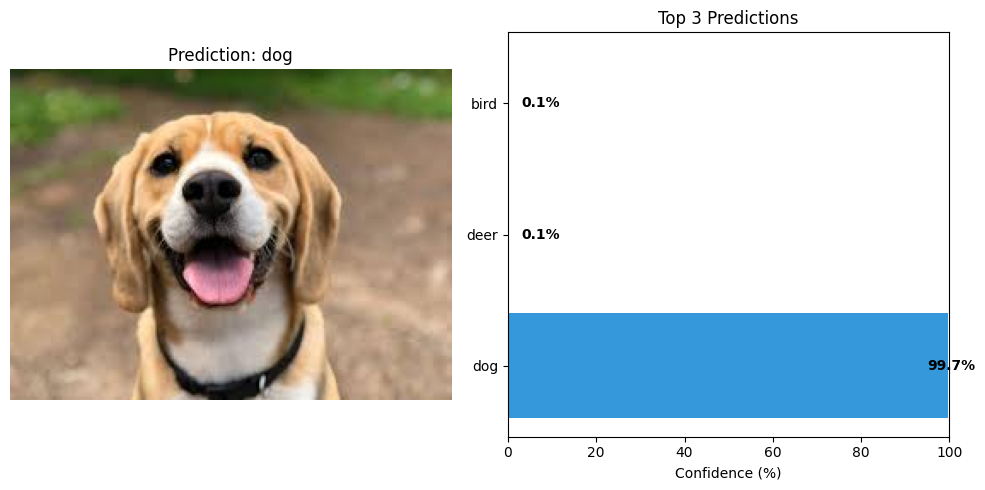


Visualizing attention map (what the model focuses on):


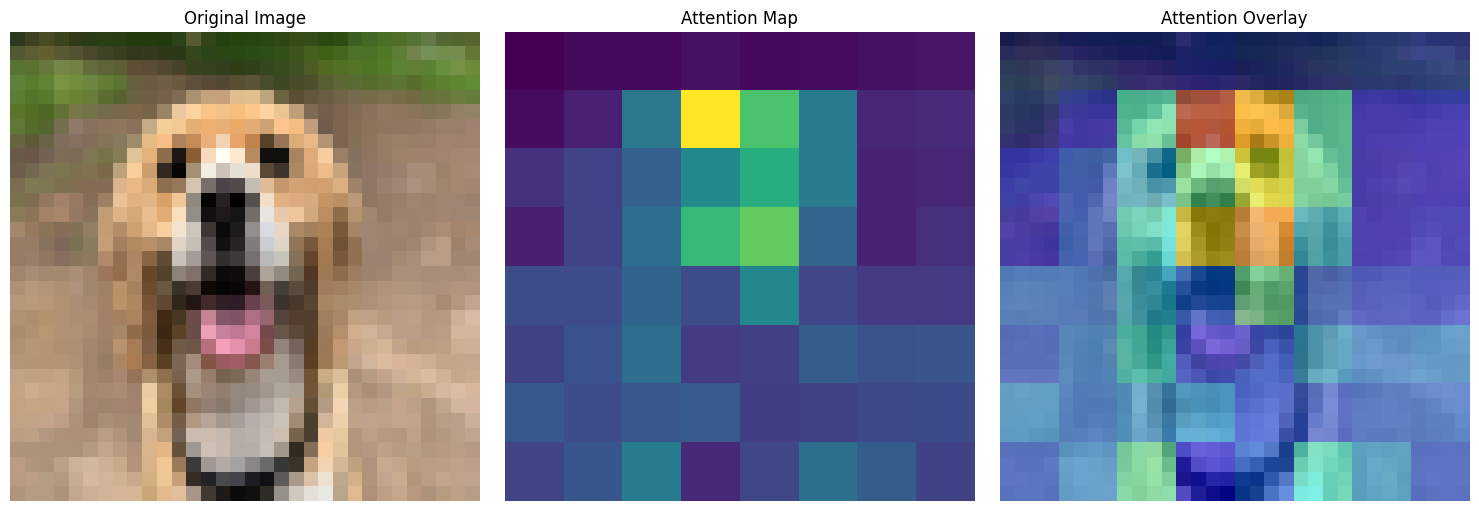


The brightness in the attention map shows which parts of the image
influenced the model's decision most strongly.


In [ ]:
# Main Execution
if __name__ == "__main__":
    run_inference()